<a href="https://colab.research.google.com/github/valentingracia/codingDojoDC/blob/main/salesPredictionProy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alumno : Valentin Gracia

Prediccion Ventas



se importa el dataset, y se despliega informacion basica

In [286]:
# Se importan las librerias

#Clásicas
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from termcolor import colored
from google.colab import output
import missingno as msno 
import matplotlib as mpl
import matplotlib.pyplot as plt

#Widgets
from ipywidgets import interact, interactive, fixed, interact_manual,IntSlider
import ipywidgets as widgets


#Modelo Lineal
from sklearn.linear_model import LinearRegression

#Modelo KNN Clasificador
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

#Modelo KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

#split
from sklearn.model_selection import train_test_split

#metricsContinuo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error






In [287]:
sales_df=pd.read_csv("/content/drive/MyDrive/Coding Dojo/salesPrediction/sales_predictions.csv")
sales_df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


#Exploración

In [288]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


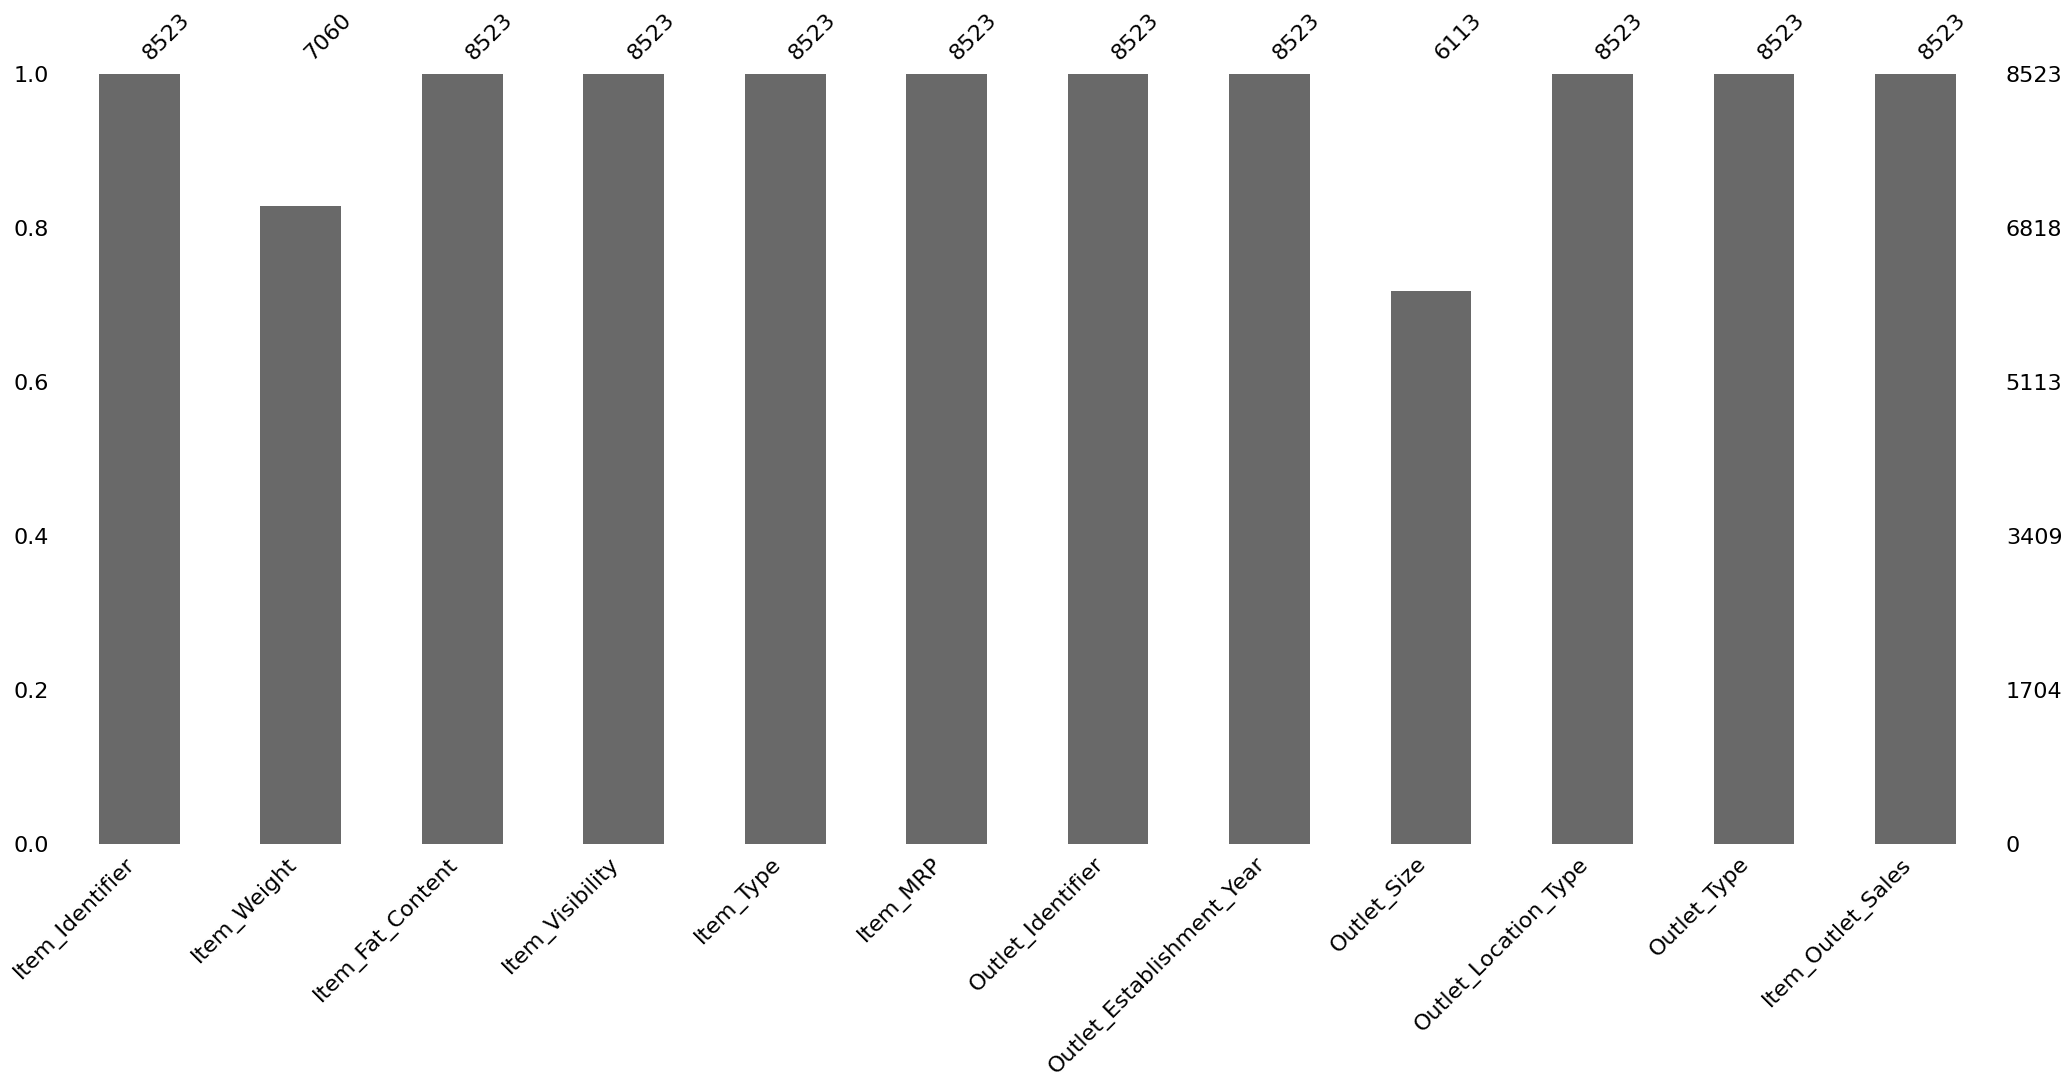

In [289]:
msno.bar(sales_df);

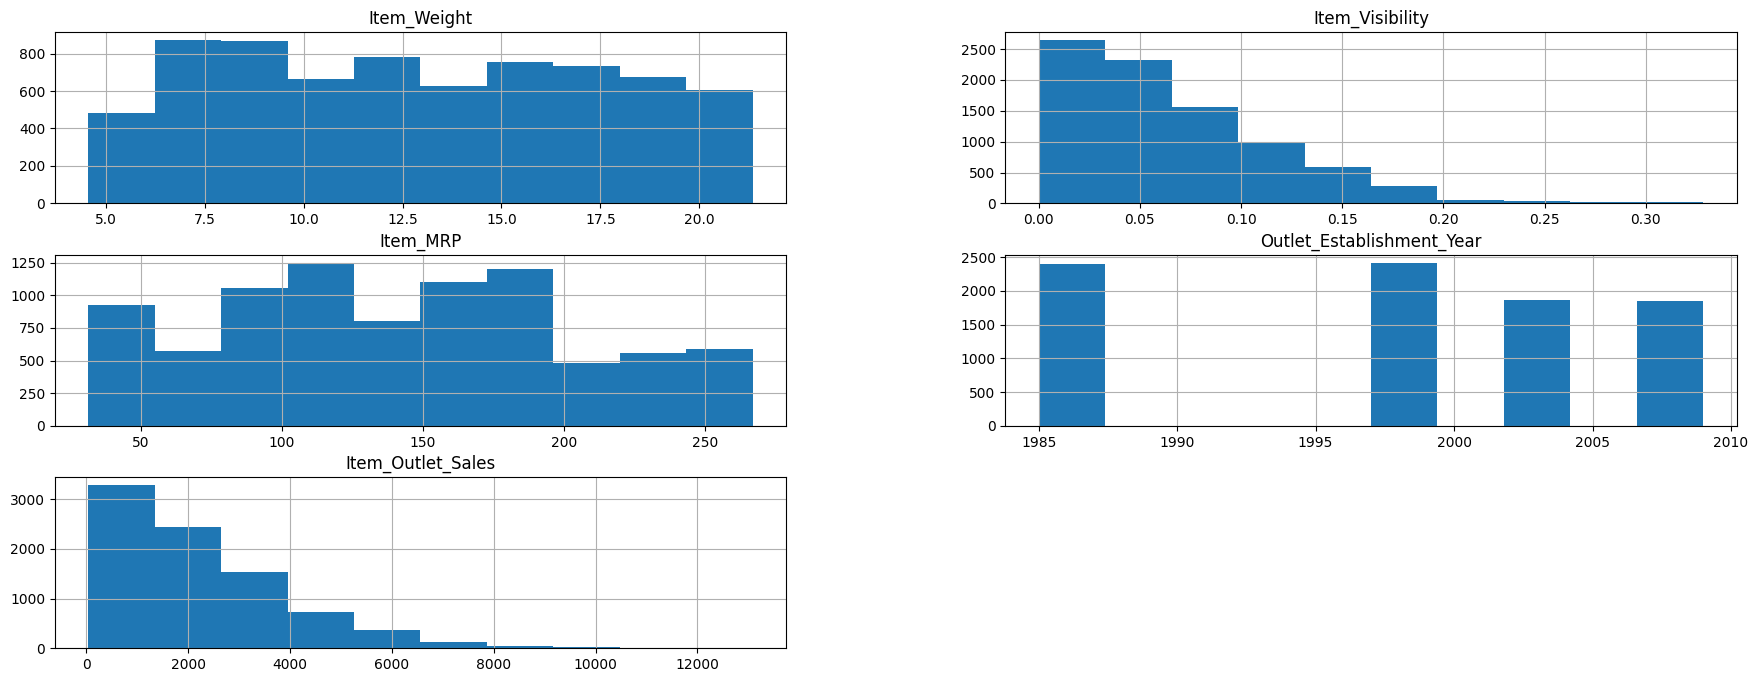

In [290]:
myLayout=(21.7,8)
sales_df.hist(figsize=myLayout);

In [291]:
from google.colab import widgets

#estoy trabajando esta funcion.
def f(x=0):
  df=sales_df
  output.clear()
  f=df.iloc[:,[x]];
  f=f.value_counts()
  f=pd.DataFrame(f)
  #print(f"csm {df.iloc[:,[x]].columns}")
  #print("Variable ", colored(f"*{df.iloc[:,[x]].column}*",'red'))
  #f.index.name =df.iloc[:,[x]].columns
  f.columns = ['count']

  print("Variable ", colored(f"*{x}*  dtype:{df.dtypes[x]}",'red'))
  print("-----")
  print(f"{len(f.index)} Categorias")
  print(f"{df.shape[0]-f.values.sum()} perdidos de  {df.shape[0]}")
  if len(f.index)== df.shape[0]:
    print("UNICO, se podria usar de indice")
 
 
  return f;
  
interact(f, x=(0,len(sales_df.columns)-1))

interactive(children=(IntSlider(value=0, description='x', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.f>

#Enmiendas

descartamos columnas con alto nivel de missings y los descartamos del analisis "

In [292]:
sales_df.drop(columns=["Item_Weight","Outlet_Size"],inplace=True)

sales_df["Item_Fat_Content"].replace({"LF": "Low Fat", "reg": "Regular","low fat":"Low Fat"}, inplace=True)
sales_df["Item_Fat_Content"].value_counts()


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

algunas vistas

In [293]:
sales_df.groupby(["Item_Fat_Content","Item_Type"])["Item_Outlet_Sales"].count()
(pd.pivot_table(sales_df, index=["Item_Type"], columns=["Item_Fat_Content"], values=["Item_Outlet_Sales"], aggfunc=np.sum,margins = True)).style.format('{0:,.0f}')

In [294]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 666.0+ KB


In [295]:
(pd.pivot_table(sales_df, index=["Outlet_Location_Type"], columns=["Item_Fat_Content"], values=["Item_Outlet_Sales"], aggfunc=np.sum,margins = True)).style.format('{0:,.0f}')

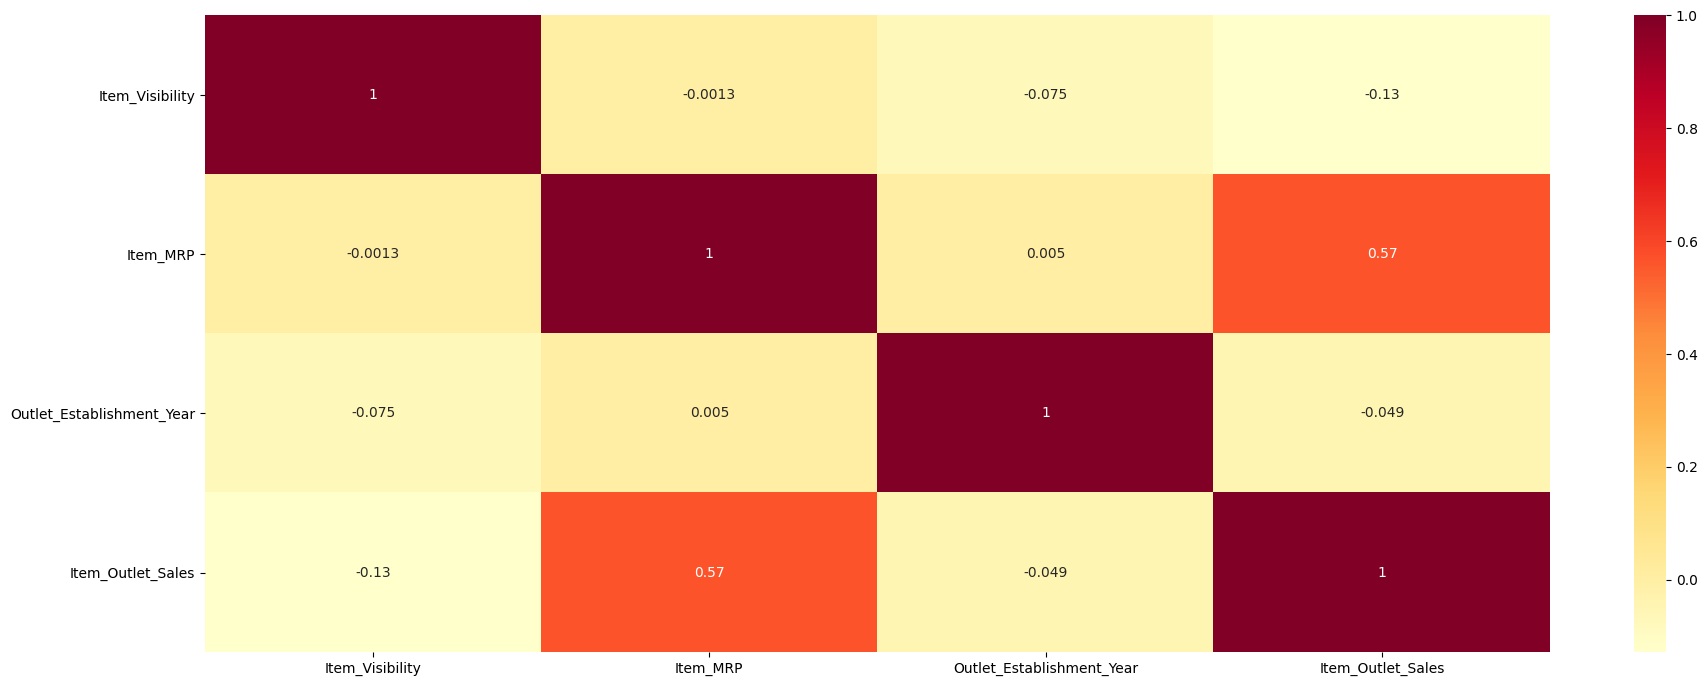

In [296]:
a4_dims = (21.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sb.heatmap(sales_df.corr(), cmap="YlOrRd", annot=True);

#KNN Regresor

In [297]:
X=sales_df.drop(columns=["Item_Outlet_Sales","Item_Identifier"])
Y=sales_df["Item_Outlet_Sales"]



In [298]:
X=pd.get_dummies(X,prefix=["Item_Fat_Content"],columns=["Item_Fat_Content"])
X=pd.get_dummies(X,prefix=["Item_Type"],columns=["Item_Type"])
X=pd.get_dummies(X,prefix=["Outlet_Identifier"],columns=["Outlet_Identifier"])
X=pd.get_dummies(X,prefix=["Outlet_Location_Type"],columns=["Outlet_Location_Type"])
X=pd.get_dummies(X,prefix=["Outlet_Type"],columns=["Outlet_Type"])

X



,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.016047,249.8092,1999,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,0.019278,48.2692,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.016760,141.6180,1999,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,0.000000,182.0950,1998,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,0.000000,53.8614,1987,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.056783,214.5218,1987,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
8519,0.046982,108.1570,2002,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
8520,0.035186,85.1224,2004,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
8521,0.145221,103.1332,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [299]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, Y)
Y_pred=neigh.predict(X)
Y_pred


  

array([3978.4879,  485.3682, 2551.6785, ..., 1561.301 , 1290.9862,
       1091.2462])

In [300]:
score=neigh.score(X,Y)
score

0.7984856285739949

nuestro modelo es explicado en un 79% por nuestro modelo.

#Regresion Lineal

In [301]:
# inicializacion
model=LinearRegression(fit_intercept=True)
#entrenamiento
model.fit(X,Y)

Y_preds=model.predict(X)

Y_preds


array([4016.92330492,  558.87249503, 2373.25192821, ..., 1524.97056896,
       1390.37883774, 1211.60622559])

In [302]:
score=model.score(X,Y)
score

0.56376350454416

Modelo lineal, predice en 56% la variabilidad, MAL.

#Preguntas 

*¿Hay algo que puedas hacer para mejorar el modelo?
Si, para el modelo KNN, podriamos buscar los K, para los cuales MSE es minimo y el R2 es maximo 

MSE=V+Sesgo**2 + Ruido

*¿Qué características están más asociadas con la predicción de ventas mayores?

-item_MRP

In [303]:
results = pd.Series(range(1))
errors = pd.Series(range(1)) 
for k in range(1,51):
  knn = KNeighborsRegressor(n_neighbors= k)  
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
  knn.fit(X_test, Y_test)
  score = knn.score(X_test, Y_test)
  results = results.append(pd.Series([score], index=[k]))
  errors = errors.append(pd.Series([1- score], index=[k]))

#con esta linea eliminamos la primera fila de la serie (punto vacío):
print(results)
results = results[1:]
errors = errors[1:]

0     0.000000
1     1.000000
2     0.792694
3     0.712857
4     0.662647
5     0.624362
6     0.593070
7     0.564637
8     0.543995
9     0.523593
10    0.510196
11    0.488986
12    0.477858
13    0.461043
14    0.448251
15    0.438912
16    0.431366
17    0.424151
18    0.416751
19    0.410967
20    0.406796
21    0.402501
22    0.399240
23    0.397396
24    0.395853
25    0.392826
26    0.388871
27    0.385487
28    0.384128
29    0.381065
30    0.379926
31    0.377529
32    0.375955
33    0.374818
34    0.373666
35    0.370890
36    0.369436
37    0.366558
38    0.365492
39    0.365476
40    0.364390
41    0.365383
42    0.363143
43    0.361110
44    0.359278
45    0.358986
46    0.357769
47    0.355800
48    0.354911
49    0.353889
50    0.352896
dtype: float64


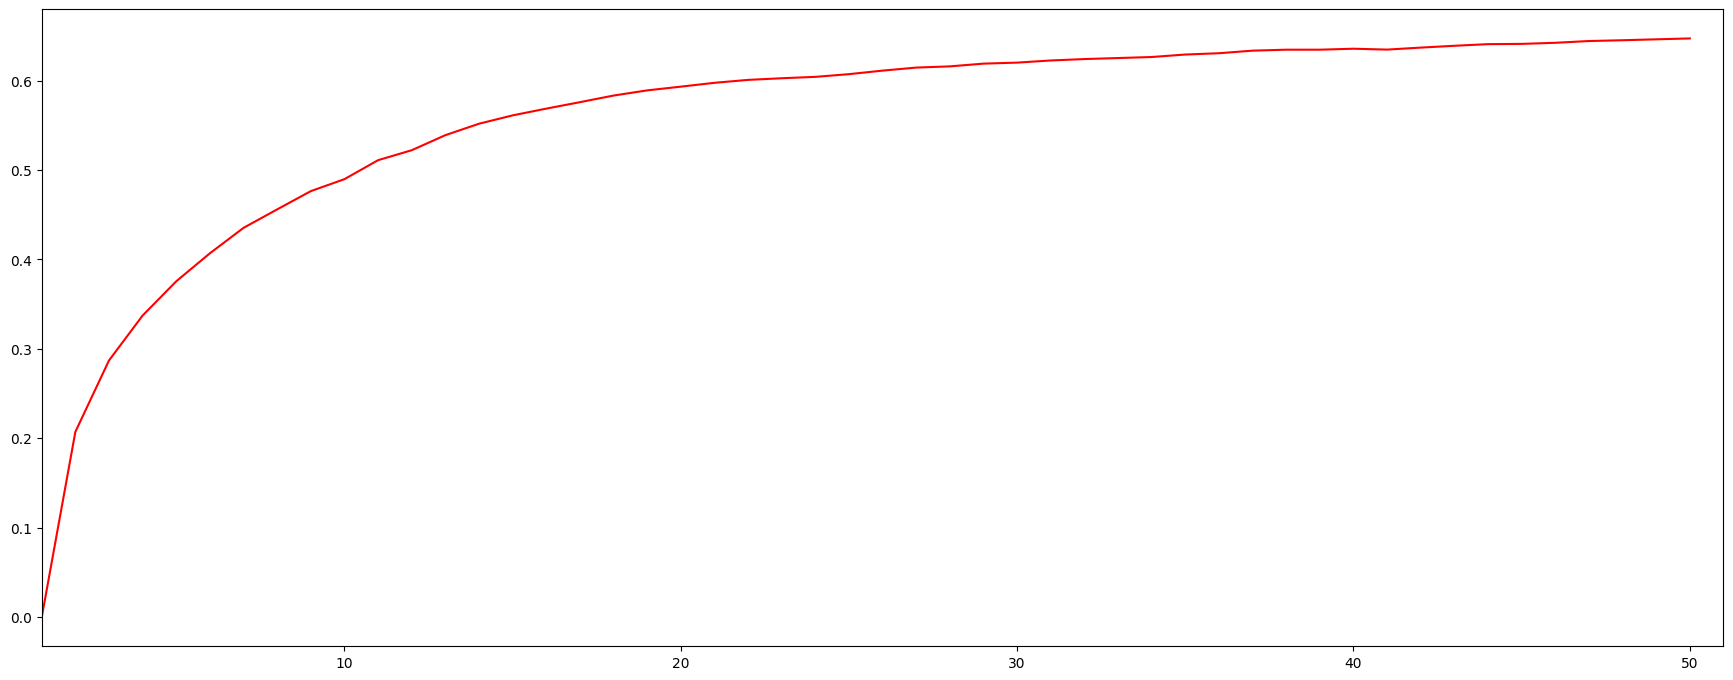

In [304]:
a4_dims = (21.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(errors.index, errors.values, color='red')
plt.xlim([1, 51])
plt.show()

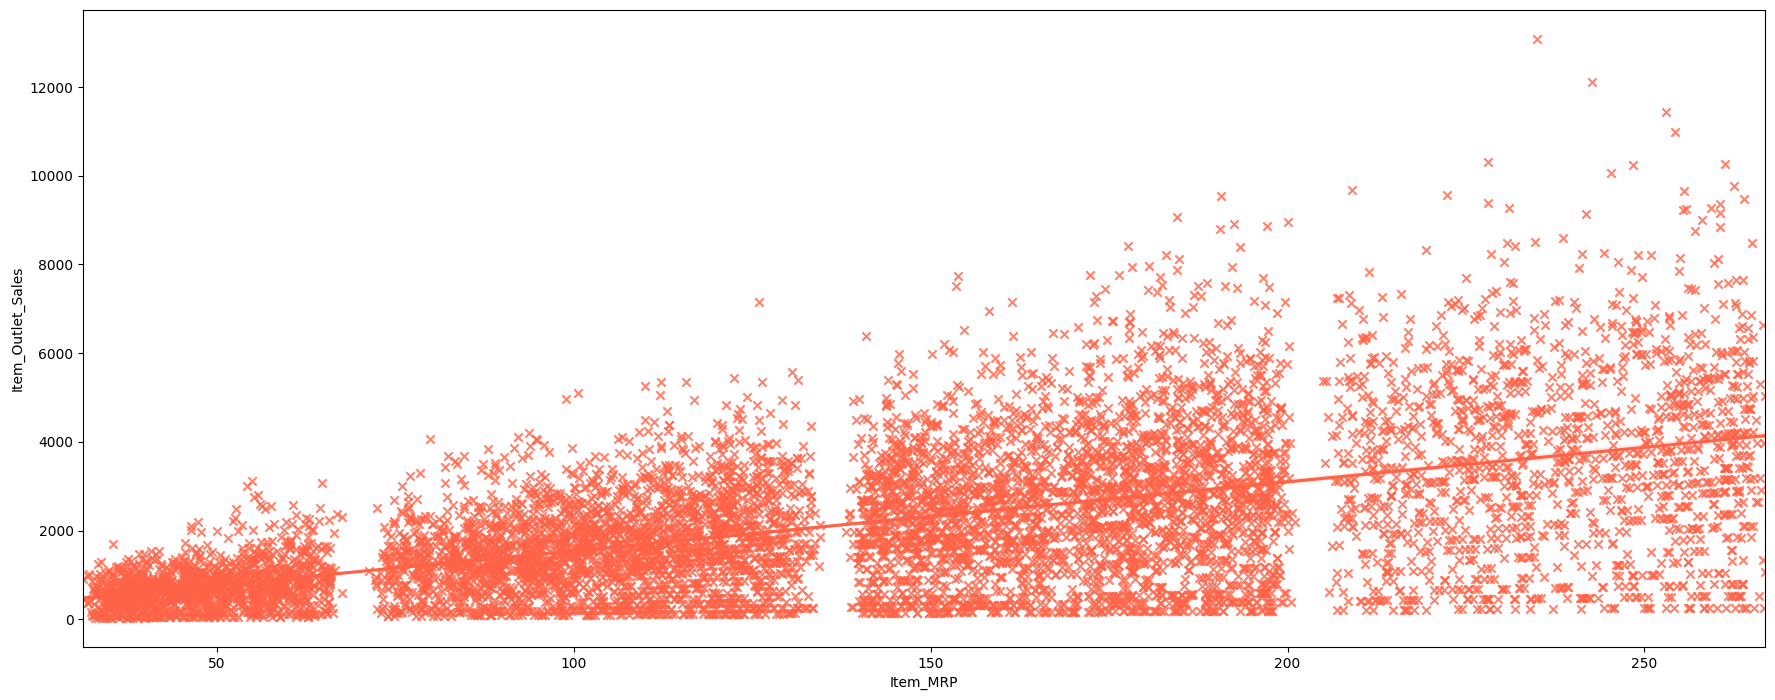

In [305]:
a4_dims = (21.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sb.regplot(x="Item_MRP",y="Item_Outlet_Sales",data=sales_df,marker="x",color="tomato");